In [2]:
#files
import sys
from os import listdir
sys.path.append('../data')
sys.path.append('../Librerias')
from os.path import isfile, join


#own libs
import utils
import caract as dc
import dataset as ds


#data and visualization
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go


#keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


sns.set_style("darkgrid")

c:\Users\consu\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## **data**

In [3]:
#fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/high/"
fpath =  "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
onlyfiles = [f for f in listdir(fpath) if isfile(join(fpath, f))]

cutoff = [8/1000, 11/1000]

#load data
frames = []
for fname in onlyfiles:
    if fname.endswith(".mat"):
        set =  ds.MatFileToDataFrame(fpath, fname)
        df = set.get_dataframe(cutoff)
        frames.append(df)
        print(fname)

file10_080124.mat
file11_080124.mat
file12_080124.mat
file13_080124.mat
file15_080124.mat
file16_080124.mat
file17_080124.mat
file18_080124.mat
file1_050124.mat
file1_080124.mat
file2_050124.mat
file3_080124.mat
file7_080124.mat
file8_080124.mat
file9_080124.mat
low1_100124.mat
low2_100124.mat
low3_100124.mat
low5_100124.mat


In [4]:
defectos_frames = []
taus = []
for i, df in enumerate(frames):
    aux = dc.CaractDefect(df)
    defectos_frames.append(aux)
    taus.append(aux.get_tau()[1])
    sys.stdout.write(str(i) + '\r')

In [5]:
hilbert_frames = []
for i, df in enumerate(defectos_frames):
    aux, _ = df.get_hilbert()
    hilbert_frames.append(aux)
    sys.stdout.write(str(i) + '\r')

In [6]:
# all frames
frames_all = []

for i in range(len(frames)):
    frames_all.append(pd.merge(frames[i], hilbert_frames[i], on='Hilbert Transform', how='outer'))

frames_all[0]

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform,Amplitude,Instantaneous Phase,Gradient Phase
0,0.076967,-0.041045,-0.005045,-0.005045+0.003866j,0.006356,2.487745,-0.050221
1,0.076638,-0.041374,-0.004841,-0.004841+0.000279j,0.004849,3.083952,-0.023636
2,0.073022,-0.044991,-0.004633,-0.004633+0.000083j,0.004634,3.123610,0.001438
3,0.073022,-0.044991,-0.004421,-0.004421-0.001203j,0.004582,3.407171,0.023619
4,0.071378,-0.046635,-0.004205,-0.004205-0.001356j,0.004419,3.453607,0.041826
...,...,...,...,...,...,...,...
599995,0.176268,0.058256,0.000015,0.000015+0.000493j,0.000493,30135.697377,-0.289769
599996,0.177254,0.059242,0.000033,0.000033+0.000343j,0.000345,30135.630801,-0.245612
599997,0.179227,0.061215,0.000050,0.000050+0.001284j,0.001285,30135.688260,-0.187389
599998,0.179885,0.061872,0.000066,0.000066+0.001095j,0.001097,30135.667052,-0.118399


In [7]:
# Extracting the required columns from frames_all[0]
data = frames_all[0][['Amplitude', 'Gradient Phase']].values

# Creating the input and target sequences
input_seq = []
target_seq = []
seq_length = 50

for i in range(len(data) - seq_length):
    input_seq.append(data[i:i+seq_length])
    target_seq.append(data[i+seq_length])

# Converting the sequences to numpy arrays
input_seq = np.array(input_seq)
target_seq = np.array(target_seq)

# Reshaping the input sequences to match the LSTM input shape
input_seq = np.reshape(input_seq, (input_seq.shape[0], input_seq.shape[1], 2))

# Creating the dataset for Keras LSTM
dataset = tf.data.Dataset.from_tensor_slices((input_seq, target_seq))

## **lstm**
lstm input 50 primera capa relu
lstm in 50, segunda capa relu
fully connected 2 units, sigmoid

In [23]:
# modelo

model = Sequential()
model.add(LSTM(units = 50, activation='relu', return_sequences=True, input_shape=(50, 2)))
model.add(LSTM(units = 50, activation='relu'))
model.add(Dense(units = 2, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])


In [25]:
# Define the number of epochs and batch size
epochs = 10
batch_size = 32

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset = dataset.take(train_size).batch(batch_size)
test_dataset = dataset.skip(train_size).batch(batch_size)

# Train the model
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)


Epoch 1/10


3881/7500 [==============>...............] - ETA: 2:30 - loss: 0.0019 - accuracy: 0.4490

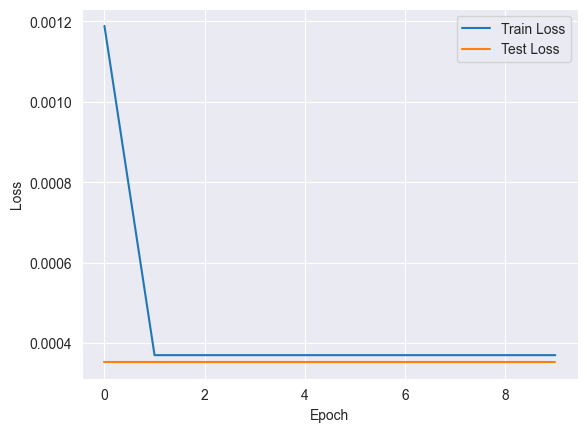

In [29]:
# Plot the train loss and test loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
filepath = "/Users/consu/OneDrive/Documentos/GitHub/Tesis/modelos/test/keras_batch64_10e.keras"
model.save(filepath, overwrite=True)

In [ ]:
predicted_values = model.predict(test_dataset)

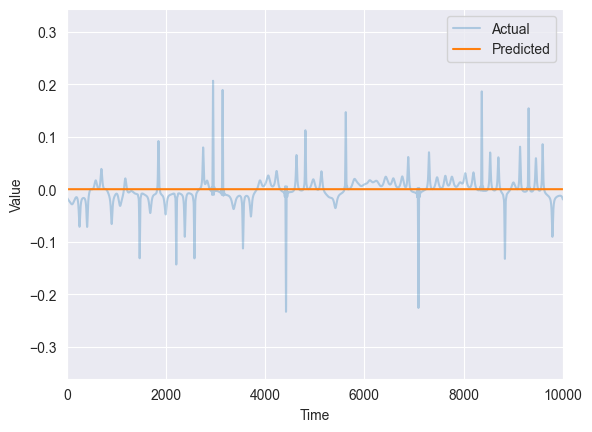

In [45]:

# Create the plt figure
plt.figure()

# Plot the predicted values
plt.plot(range(len(target_seq)), target_seq[:, 1], label='Actual', alpha = 0.3)
plt.plot(range(len(predicted_values)), predicted_values[:, 1], label='Predicted')

# Plot the actual values

plt.xlim((0,10000))
# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('Value')

# Show the legend
plt.legend()

# Show the plt figure
plt.show()


## **lstm 2**

In [19]:

model = Sequential()
model.add(LSTM(units = 50, activation='relu', return_sequences=True, input_shape=(50, 2)))
model.add(LSTM(units = 50, activation='relu'))
model.add(Dense(units = 2, activation = 'relu'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[keras.metrics.MeanAbsolutePercentageError()])


In [20]:
# Define the number of epochs and batch size
epochs = 10
batch_size = 32

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset = dataset.take(train_size).batch(batch_size)
test_dataset = dataset.skip(train_size).batch(batch_size)

# Train the model
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/10


14999/14999 [==============================] - 843s 56ms/step - loss: 3.6947e-04 - accuracy: 0.4875 - val_loss: 3.5264e-04 - val_accuracy: 0.4919
Epoch 2/10
14999/14999 [==============================] - 1017s 68ms/step - loss: 3.6947e-04 - accuracy: 0.4875 - val_loss: 3.5264e-04 - val_accuracy: 0.4919
Epoch 3/10
14999/14999 [==============================] - 863s 58ms/step - loss: 3.6947e-04 - accuracy: 0.4875 - val_loss: 3.5264e-04 - val_accuracy: 0.4919
Epoch 4/10
14999/14999 [==============================] - 1529s 102ms/step - loss: 3.6947e-04 - accuracy: 0.4875 - val_loss: 3.5264e-04 - val_accuracy: 0.4919
Epoch 5/10
14999/14999 [==============================] - 905s 60ms/step - loss: 3.6947e-04 - accuracy: 0.4875 - val_loss: 3.5264e-04 - val_accuracy: 0.4919
Epoch 6/10
14999/14999 [==============================] - 1051s 70ms/step - loss: 3.6947e-04 - accuracy: 0.4875 - val_loss: 3.5264e-04 - val_accuracy: 0.4919
Epoch 7/10
14999/14999 [==============================] - 824s 55

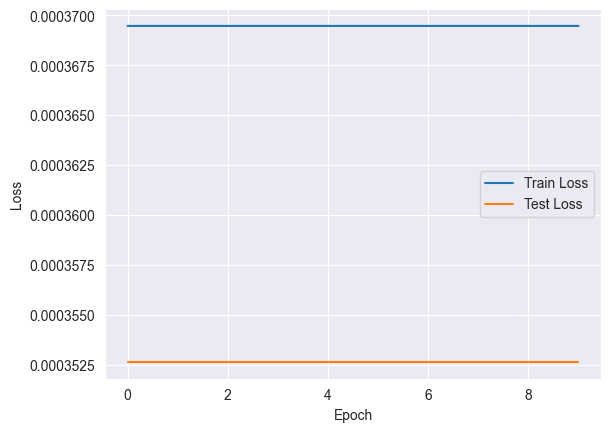

In [21]:
# Plot the train loss and test loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
predicted_values = model.predict(test_dataset)

3750/3750 [==============================] - 58s 15ms/step


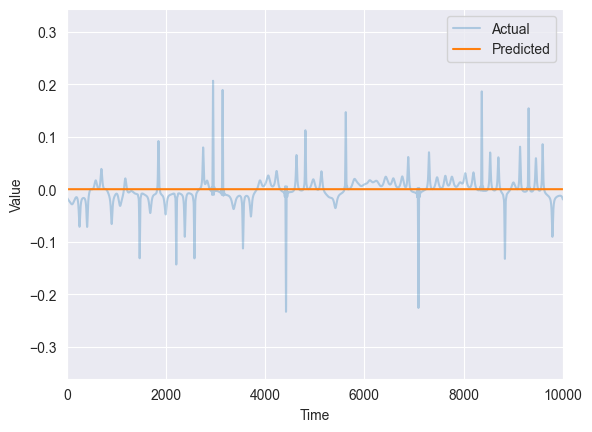

In [23]:
# Create the plt figure
plt.figure()

# Plot the predicted values
plt.plot(range(len(target_seq)), target_seq[:, 1], label='Actual', alpha = 0.3)
plt.plot(range(len(predicted_values)), predicted_values[:, 1], label='Predicted')

# Plot the actual values

plt.xlim((0,10000))
# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('Value')

# Show the legend
plt.legend()

# Show the plt figure
plt.show()